# LDTk example 1: basics

**Last updated: 2.5.2020**<br>
**LDTk version: 1.1**

This first example covers the basics of LDTk. We learn how to set up filters, how to use ``LDPSetCreator`` to create a set of limb darkening profiles as instances of ``LDPSet`` class, how to use these instances to estimate limb darkening coefficients from the profiles, and how to evaluate the limb darkening model likelihood directly from the profiles.

In [1]:
%pylab inline
from IPython.display import display, Latex
import seaborn as sb
sb.set_context('notebook')
sb.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


## Initialisation

In [2]:
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from ldtk.filters import sdss_g, sdss_r, sdss_i, sdss_z

First, we initialise a ``LDPSetCreator`` with the stellar parameter estimates and our filter set. This may take some time, since we also need to download the necessary model spectra to a local cache directory (can be several hundreds of MB).

In [3]:
sc = LDPSetCreator(teff=(5500,100), logg=(4.5,0.2), z=(0.25,0.05),
                   filters=[sdss_g, sdss_r, sdss_i, sdss_z], dataset='vis-lowres')


Need to download 78 files, approximately 26.05 MB


Next, we create the limb darkening profiles with their uncertainties for each filter, all contained in an ``LDPSet`` object.

In [4]:
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(300)

## Limb darkening profile visualisation

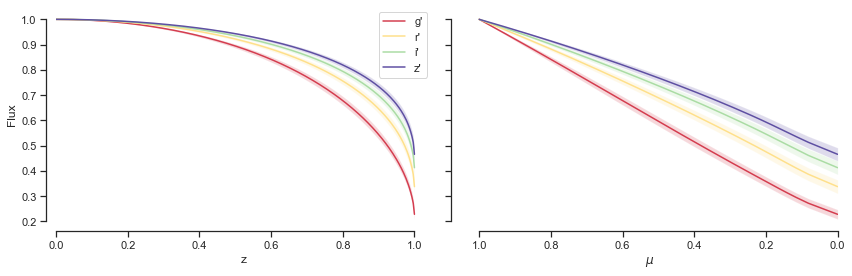

In [5]:
cmap = cm.get_cmap("Spectral")
cp = cmap(linspace(0.1,1.0,4))
fig,ax = subplots(1, 2, figsize=(12,4), sharey=True)
for i in range(ps._nfilters):
    ax[0].fill_between(ps._z, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[0].plot(ps._z, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
    ax[1].fill_between(ps._mu, ps._mean[i]-3*ps._std[i], ps._mean[i]+3*ps._std[i], 
                    facecolor=cp[i], alpha=0.2)
    ax[1].plot(ps._mu, ps._mean[i], '-', c=cp[i], label=ps._filters[i])
ax[0].legend()
setp(ax[0], xlim=(0,1.05), ylim=(0.2,1.05), xlabel='z', ylabel='Flux')
setp(ax[1], xlim=(1.05,0), ylim=(0.2,1.05), xlabel='$\mu$')
sb.despine(fig, offset=10, trim=True)
setp(ax[1].get_yticklabels(), visible=False)
fig.tight_layout()

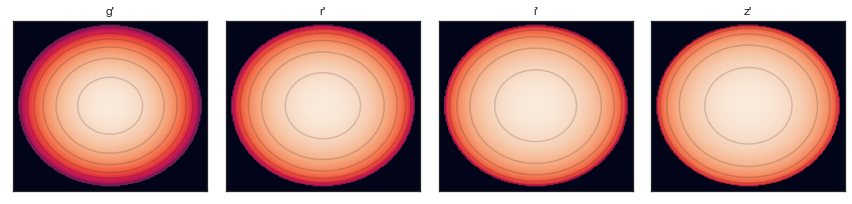

In [6]:
x,y = meshgrid(linspace(-1.05, 1.05, 150), linspace(-1.05, 1.05, 150))
r = sqrt(x**2+y**2)

profiles = ps.profile_averages
fig, axs = subplots(1, 4, figsize=(12,3), sharex=True, sharey=True)
for i,ldp in enumerate(profiles):
    axs.flat[i].imshow(interp(r, ps._z, ldp, left=0, right=0), 
                       vmin=0, vmax=1, aspect='auto', extent=(-1.05,1.05,-1.05,1.05))
    axs.flat[i].contour(x, y, interp(r, ps._z, ldp, left=0, right=0), colors='k', alpha=0.15,
                        levels=[0.0, 0.25, 0.4, 0.55, 0.65, 0.75, 0.85, 0.95, 1])
    axs.flat[i].set_title(ps._filters[i])
setp(axs, xticks=[], yticks=[])
fig.tight_layout()

## Limb darkening coefficient estimation

The ``LDPSet`` class offers methods to estimate the limb darkening model coefficients for each filter. These methods are called ``coeffs_xx`` where ``xx`` can be

  - ``ln``:  linear model    (1 coeff)
  - ``qd``:  quadratic model (2 coeffs)
  - ``sq``:  square-root model (2 coeffs)
  - ``nl``:  nonlinear model (4 coeffs)
  - ``ge``:  general model   (n coeffs)
  - ``tq``:  triangular quadratic model (2 coeffs)
  - ``p2``:  Power-2 model (2 coeffs)
  - ``p2mp``: Power-2 model with an alternative parametrization (2 coeffs)
  
For the quadratic model

In [7]:
qc, qe = ps.coeffs_qd()

In [8]:
for i, (c, e) in enumerate(zip(qc, qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can also use MCMC to estimate the coefficient uncertainties (or the full covariance matrix) more accurately:

In [9]:
qc, qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)

In [10]:
for i, (c, e) in enumerate(zip(qc, qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Finally, we can decide we don't trust the stellar models the profiles were computed from too much, and set an multiplicative factor on the profile uncertainties. 

In [11]:
ps.set_uncertainty_multiplier(2)

qc, qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)

for i, (c, e) in enumerate(zip(qc, qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Likelihood evaluation

We can also directly evaluate the likelihood for a model. This can be done for a single passband

In [12]:
print(ps.lnlike_qd([0.69, 0.15], flt=0))

977.6008694082303


jointly for all passbands

In [13]:
print(ps.lnlike_qd([[0.69, 0.15], [0.48 ,0.16], [0.38, 0.15], [0.38, 0.10]]))

-50952.57815763505


or in parallel for a number of coefficient sets, what can be useful when using population-based optimizers or MCMC samplers, such as emcee

In [14]:
print(ps.lnlike_qd([[[0.69, 0.15], [0.48 ,0.16], [0.38, 0.15], [0.38, 0.10]],
                    [[0.66, 0.12], [0.43 ,0.12], [0.35, 0.14], [0.37, 0.13]]]))

[ 1806.54576396 -4247.98935298]


---
<center> &copy; 2015&ndash;2020 <a href="mailto:hannu@iac.es">Hannu Parviainen</a></center>